- Previous Day
- MA
- EWMA
- Tree based models
- LSTM
- We can consider date related features as well
    - Here it won't matter since things are sine waves

In [3]:

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [40]:
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv("fake-cpc.csv")
df['date'] = pd.to_datetime(df['date'])

In [18]:
def generate_price_chart(df, ewmas=[]):
    plt.figure(figsize=(16, 8))
    handles = []
    p1, = plt.plot(df['date'],df['cpc'], label="CPC")
    handles.append(p1)
    for ewma in ewmas:
        y = df['cpc'].ewm(span=ewma).mean()
        p2, = plt.plot(df['date'],y, label="%s day ewma" % ewma)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title("CPC Prices")
    plt.ylabel('CPC')
    plt.show()

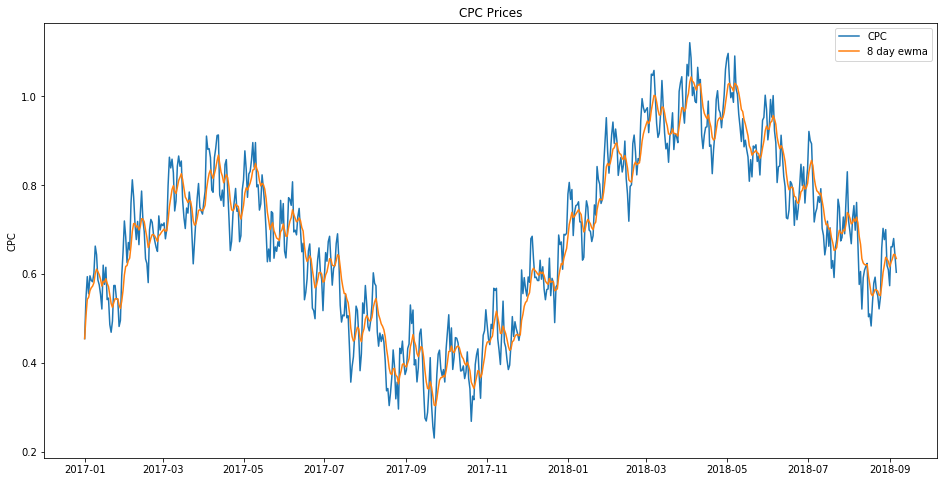

In [41]:
generate_price_chart(df,ewmas=[8])

### Last day as prediction for today

In [21]:
preds = df['cpc'].shift(1).fillna(df['cpc'].mean())

In [24]:
error = np.sqrt(mean_squared_error(df['cpc'],preds))
print("Error using last day's pred: %.4f"%error)

Error using last day's pred: 0.0525


### Using Moving Average
- Finding Best rolling window

In [36]:
min_error = 1e8
best_window = 2
for i in range(2,8):
    preds = df['cpc'].shift(1).fillna(0).rolling(window=i).mean().fillna(0)
    error = np.sqrt(mean_squared_error(df['cpc'],preds))
    print("Error using %s days MA pred: %.4f"%(i,error))
    if min_error>error:
        min_error=error
        best_window=i
        
print("Best Window %s with min error: %.4f"%(best_window,min_error))

Error using 2 days MA pred: 0.0608
Error using 3 days MA pred: 0.0695
Error using 4 days MA pred: 0.0752
Error using 5 days MA pred: 0.0780
Error using 6 days MA pred: 0.0799
Error using 7 days MA pred: 0.0823
Best Window 2 with min error: 0.0608


### Using Exponential Moving Average
- Finding Best rolling window

In [37]:
min_error = 1e8
best_window = 2
for i in range(2,8):
    preds = df['cpc'].shift(1).fillna(0).ewm(span=i).mean().fillna(0)
    error = np.sqrt(mean_squared_error(df['cpc'],preds))
    print("Error using %s days MA pred: %.4f"%(i,error))
    if min_error>error:
        min_error=error
        best_window=i
        
print("Best Window %s with min error: %.4f"%(best_window,min_error))

Error using 2 days MA pred: 0.0567
Error using 3 days MA pred: 0.0588
Error using 4 days MA pred: 0.0604
Error using 5 days MA pred: 0.0620
Error using 6 days MA pred: 0.0635
Error using 7 days MA pred: 0.0649
Best Window 2 with min error: 0.0567


### Using a Tree Based Model XGBoost

In [93]:
df['cpc_1'] = df['cpc'].shift(1)
df['cpc_ewma_2'] = df['cpc'].shift(1).fillna(0).ewm(span=2).mean()
df['cpc_ewma_4'] = df['cpc'].shift(1).fillna(0).ewm(span=4).mean()
df['cpc_ewma_8'] = df['cpc'].shift(1).fillna(0).ewm(span=8).mean()
df['cpc_ewma_12'] = df['cpc'].shift(1).fillna(0).ewm(span=12).mean()

da8 = np.diff(df['cpc_ewma_8'].shift(1))
df['cpc_ewma_8_gradient'] = np.concatenate(([0],da8))

da8 = np.diff(df['cpc_ewma_8'].shift(2),n=2)
df['cpc_ewma_8_gradient_twice'] = np.concatenate(([0,0],da8))

features = ['cpc_1','cpc_ewma_2','cpc_ewma_4','cpc_ewma_8','cpc_ewma_12','cpc_ewma_8_gradient','cpc_ewma_8_gradient_twice']
X = df[features]
y = df['cpc']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = XGBRegressor(max_depth=3,n_estimators=7,learning_rate=0.4).fit(X_train,y_train)
tpred = model.predict(X_train)
train_error = np.sqrt(mean_squared_error(y_train,tpred))
print("Training error using tree: %s"%train_error)

pred = model.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,pred))
print("Test error using tree: %s"%error)

<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'CPC Prediction with Tree Model, error: 0.0563')

Text(0,0.5,'CPC')

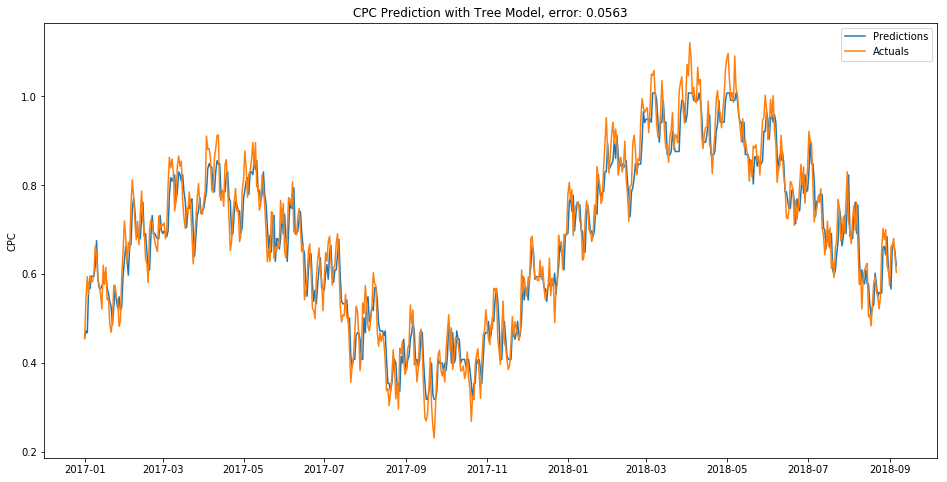

In [89]:
all_preds = model.predict(X)
plt.figure(figsize=(16, 8))
handles = []
p2, = plt.plot(df['date'],all_preds,label="Predictions")
handles.append(p2)
p2, = plt.plot(df['date'],y,label="Actuals")
handles.append(p2)
plt.legend(handles=handles)
plt.title("CPC Prediction with Tree Model, error: %.4f"%(error))
plt.ylabel('CPC')
plt.show()

In [94]:
train_len = 500
test_len = len(df)-train_len
df_train = df.head(train_len)
df_test = df.tail(test_len)

X_train,y_train = df_train[features],df_train['cpc']
X_test,y_test = df_test[features],df_test['cpc']

model = XGBRegressor(max_depth=3,n_estimators=7,learning_rate=0.4).fit(X_train,y_train)
tpred = model.predict(X_train)
train_error = np.sqrt(mean_squared_error(y_train,tpred))
print("Training error using tree: %s"%train_error)

pred = model.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,pred))
print("Test error using tree: %s"%error)

Training error using tree: 0.044607808342350216
Test error using tree: 0.050521590243782055


<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'CPC Prediction with Tree Model, error: 0.0505')

Text(0,0.5,'CPC')

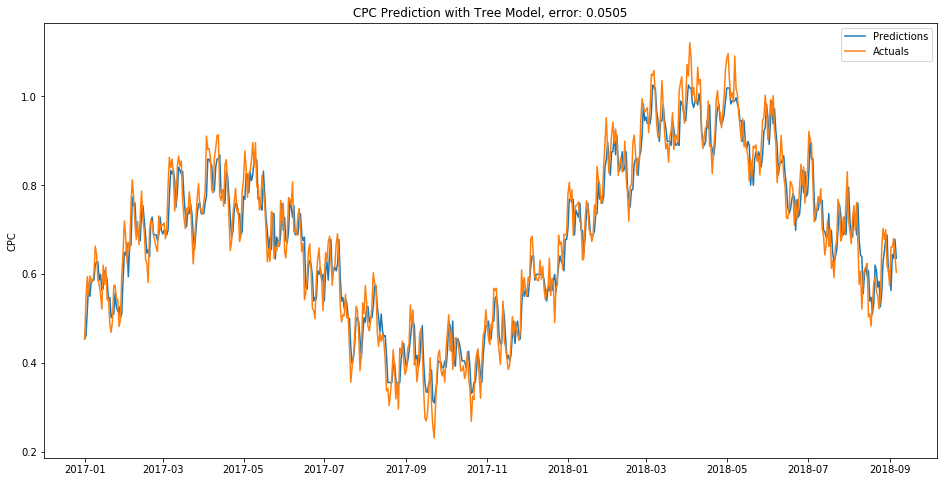

In [95]:
all_preds = model.predict(X)
plt.figure(figsize=(16, 8))
handles = []
p2, = plt.plot(df['date'],all_preds,label="Predictions")
handles.append(p2)
p2, = plt.plot(df['date'],y,label="Actuals")
handles.append(p2)
plt.legend(handles=handles)
plt.title("CPC Prediction with Tree Model, error: %.4f"%(error))
plt.ylabel('CPC')
plt.show()

In [96]:
# feature importances
def feature_importance(model,df,features):
    fi = None
    df = df.head()
    if hasattr(model, 'feature_importances_'):
        fi=model.feature_importances_
    elif hasattr(model, 'coef_'):
        fi = model.coef_
    else:
        raise AttributeError('No attribute: feature_importances_ or  coef_')
    fn=df[features].columns.values
    df_i=pd.DataFrame({"feature":fn,"importance":fi})
    df_i["importance"] = df_i["importance"]*100
    return df_i.sort_values("importance",ascending=False)
feature_importance(model,df,features)


,feature,importance
0,cpc_1,48.979591
3,cpc_ewma_8,16.326530
6,cpc_ewma_8_gradient_twice,12.244898
4,cpc_ewma_12,8.163265
5,cpc_ewma_8_gradient,6.122449
1,cpc_ewma_2,4.081633
2,cpc_ewma_4,4.081633


### LSTM 

- https://www.upwork.com/ab/proposals/1038056158170066945